# Data preprocessing Notebook
This notebook shows how the Bloomberg & Reuters dataset was preprocessed and used to create our financial news headlines dataset for sentiment analysis.

## Modules

In [1]:
import pandas as pd
import os
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
from datetime import timezone
import pytz

In [2]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

## Bloomberg dataset

### Text encoding for news files

In [ ]:
def read_file(file_path):    
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'windows-1252', 'utf-16']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                text = file.read()
                return text
                
        except UnicodeDecodeError:
            continue  # Try the next encoding
            
    print(f"Could not read file {file_path} with any of the specified encodings.")

    return None

### Match the timestamp format

In [4]:
def extract_timestamp(text):
    ts_pattern = r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z'
    match = re.search(ts_pattern, text)
    if match:
        return datetime.fromisoformat(match.group().replace('Z', '+00:00'))
        
    return None

### Match the headline format 

In [5]:
def extract_headline(text):
    lines = text.split('\n')
    for i, line in enumerate(lines):
        if '--' in line:
            # The headline might be on this line after '--', or on the next line
            parts = line.split('--', 1) # Split the line at the first occurrence of '--'
            if len(parts) > 1 and parts[1].strip(): # If there is text following '--'
                return parts[1].strip()
                
            elif i + 1 < len(lines): # If there is a next line
                next_line = lines[i + 1].strip()
                if next_line:
                    return next_line    
            break
            
    return None

### Create the DataFrame (batch processing)

In [2]:
bloomberg_dir = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Datasets/Sentiment Analysis/Bloomberg'

In [7]:
batch_size=2000

In [8]:
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(bloomberg_dir) for f in filenames if f != '.DS_Store']
num_batches = len(all_files) // batch_size + (1 if len(all_files) % batch_size else 0)

In [9]:
def create_bloomberg():
    bloomberg_data = []
    missing_data_files = 0
    
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        batch_files = all_files[start_index:end_index]
        
        print(f"Processing batch {i+1}/{num_batches}...")  # Progress update

        for file_path in batch_files:
            content = read_file(file_path)
            if content:
                timestamp = extract_timestamp(content)
                headline = extract_headline(content)
                if timestamp and headline:
                    bloomberg_data.append({'timestamp': timestamp, 'headline': headline})
                
                else:
                    missing_data_files += 1
            
            else:
                missing_data_files += 1
                
        bloomberg_df = pd.DataFrame(bloomberg_data, columns=['timestamp', 'headline'])
        
    print(f"Missing data in {missing_data_files} files.")
    return bloomberg_df

In [76]:
bloomberg_df = create_bloomberg()

Processing batch 1/225...
Processing batch 2/225...
Processing batch 3/225...
Processing batch 4/225...
Processing batch 5/225...
Processing batch 6/225...
Processing batch 7/225...
Processing batch 8/225...
Processing batch 9/225...
Processing batch 10/225...
Processing batch 11/225...
Processing batch 12/225...
Processing batch 13/225...
Processing batch 14/225...
Processing batch 15/225...
Processing batch 16/225...
Processing batch 17/225...
Processing batch 18/225...
Processing batch 19/225...
Processing batch 20/225...
Processing batch 21/225...
Processing batch 22/225...
Processing batch 23/225...
Processing batch 24/225...
Processing batch 25/225...
Processing batch 26/225...
Processing batch 27/225...
Processing batch 28/225...
Processing batch 29/225...
Processing batch 30/225...
Processing batch 31/225...
Processing batch 32/225...
Processing batch 33/225...
Processing batch 34/225...
Processing batch 35/225...
Processing batch 36/225...
Processing batch 37/225...
Processing

### Sort and preprocess the data

In [86]:
# Format the timestamp 
bloomberg_df['timestamp'] = pd.to_datetime(bloomberg_df['timestamp']).dt.strftime('%Y-%m-%d %H:%M')

In [89]:
bloomberg_df.sort_values(by='timestamp', inplace=True)

### Save the DataFrame into a .CSV file

In [91]:
bloomberg_df.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Bloomberg/Bloomberg.csv', index=False)

### Plot the bar chart

In [49]:
def create_bar(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['weekday'] = df['timestamp'].dt.day_name()
    day_of_week_counts = df['weekday'].value_counts()
    
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_of_week_counts = day_of_week_counts.reindex(order)
    
    plt.figure(figsize=(5, 3))
    ax = day_of_week_counts.plot(kind='bar', color=(0.2, 0.4, 0.6), width=0.8)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
               
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
    plt.show()

### Plot the time-series gragh

In [32]:
def create_timeSeries(df):
    # Ensure the 'timestamp' column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract just the date part if the time isn't relevant
    df['date'] = df['timestamp'].dt.date
    
    # Count the number of news articles per day
    news_counts = df['date'].value_counts().sort_index()
    
    plt.figure(figsize=(4.9, 3.3))
    plt.bar(news_counts.index, news_counts.values, color=(0.2, 0.4, 0.6), width=1.0)
    
    # Formatting the date to show only the beginning of each year on the x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
    plt.show()

### Data distribution

#### Over weekdays

In [93]:
bloomberg_df_copy = bloomberg_df.copy(deep=True)

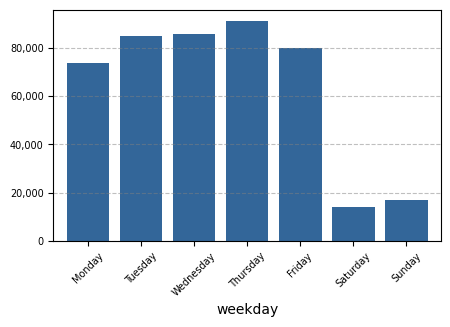

In [50]:
create_bar(bloomberg_df_copy)

In [101]:
bloomberg_df_copy.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Bloomberg/Bloomberg_copy.csv', index=False)

#### News articles publsiehd per day/year

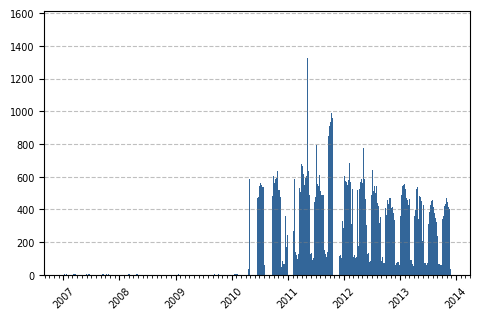

In [33]:
create_timeSeries(bloomberg_df_copy)

## Reuters

In [10]:
reuters_dir = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Datasets/Sentiment Analysis/Reuters'

### Create the DataFrame (batch processing)

In [18]:
batch_size = 200
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(reuters_dir) for f in filenames if f.endswith('.tsv')]
num_batches = len(all_files) // batch_size + (1 if len(all_files) % batch_size else 0)

In [19]:
def create_reuters():
    
    reuters_data = []
    
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        batch_files = all_files[start_index:end_index]
        
        print(f"Processing batch {i+1}/{num_batches}...")  # Progress update

        for file_path in batch_files:
            df = pd.read_csv(file_path, sep='\t', usecols=['ts', 'title'])
            reuters_data.append(df)

    reuters_df = pd.concat(reuters_data, ignore_index=True)
    
    return reuters_df

In [20]:
reuters_df = create_reuters()

Processing batch 1/18...
Processing batch 2/18...
Processing batch 3/18...
Processing batch 4/18...
Processing batch 5/18...
Processing batch 6/18...
Processing batch 7/18...
Processing batch 8/18...
Processing batch 9/18...
Processing batch 10/18...
Processing batch 11/18...
Processing batch 12/18...
Processing batch 13/18...
Processing batch 14/18...
Processing batch 15/18...
Processing batch 16/18...
Processing batch 17/18...
Processing batch 18/18...


In [21]:
print(reuters_df)

                            ts  \
0        20070627 11:59 PM EDT   
1        20070627 11:43 PM EDT   
2        20070627 11:40 PM EDT   
3        20070627 11:40 PM EDT   
4        20070627 11:40 PM EDT   
...                        ...   
8552064   20131110  6:54AM UTC   
8552065   20131110  3:09AM UTC   
8552066   20131110  2:40AM UTC   
8552067   20131110  2:39AM UTC   
8552068  20131110  12:46AM UTC   

                                                     title  
0        Southern Copper Peru workers call for strike t...  
1        Red Sox's Schilling will not pitch again until...  
2          TREASURIES-Futures inch down in Asia before Fed  
3        FOREX-Yen breaks 3-day rise as risk-aversion e...  
4                      Clemens still waiting for 350th win  
...                                                    ...  
8552064           Bo supporters set up new political party  
8552065            Residents try to relocate after typhoon  
8552066  GRAPHIC IMAGES: 10,000 deaths rep

### Sort and preprocess the data

In [26]:
# Rename the columns
reuters_df.rename(columns={'ts': 'timestamp', 'title': 'headline'}, inplace=True)

In [46]:
# Rows where timestamp is invalid
index_label = [127460, 484840, 1116016, 2151064, 2225415, 3435406, 3802752, 4306751, 4498612, 5323098, 5407070, 6002269, 6157604, 6527049, 6925399]
row_values = reuters_df.loc[index_label]
print(row_values)

            timestamp                                           headline
127460   INVALID_DATE   Effective Control Transport Inc. Article in C...
484840   INVALID_DATE      <strong>reached an agreement with GM</strong>
1116016  INVALID_DATE   Video Message From Her Excellency the Right H...
2151064  INVALID_DATE  <strong>bolstered by a new California rule</st...
2225415  INVALID_DATE                <strong>raised $10 million</strong>
3435406  INVALID_DATE                                 spain's santander 
3802752  INVALID_DATE                                        TABLE-TIDE 
4306751  INVALID_DATE  KUWAIT'S NATIONAL MOBILE TELECOMMUNICATIONS CO...
4498612  INVALID_DATE                  The Levi`s Brand Introduces Water
5323098  INVALID_DATE                  TEXT-Fitch cuts Victoria Funding 
5407070  INVALID_DATE                The Levi'sÂ® Brand Introduces Water
6002269  INVALID_DATE   Message from Her Excellency the Right Honoura...
6157604  INVALID_DATE  8 Bottles, 1 Jean - The Levi

In [50]:
reuters_df = reuters_df.drop(reuters_df.index[index_label])

In [55]:
tzinfos = {
    "EDT": pytz.timezone("America/New_York"),
    "EST": pytz.timezone("America/New_York"),
    "UTC": pytz.utc,
}

In [56]:
# Convert the timestamp format to match the Bloomberg dataset
def convert_timestamp(ts):
    try:
        dt = parser.parse(ts, tzinfos=tzinfos)
        dt_utc = dt.astimezone(pytz.utc)
        return dt_utc.strftime('%Y-%m-%d %H:%M')
        
    except ValueError:
        return None

In [57]:
reuters_df['timestamp'] = reuters_df['timestamp'].apply(convert_timestamp)

In [59]:
reuters_df.sort_values(by='timestamp', inplace=True)

### Save the DataFrame to a CSV file

In [61]:
reuters_df.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Reuters/Reuters.csv', index=False)

### Data distribution

#### Over weekdays

In [62]:
reuters_df_copy = reuters_df.copy(deep=True)

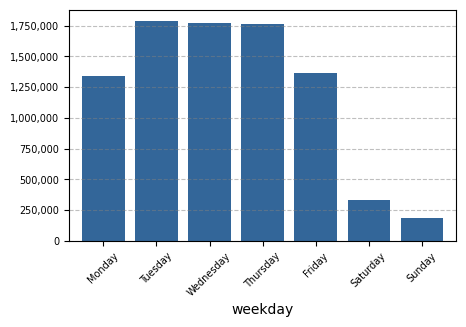

In [68]:
create_bar(reuters_df_copy)

In [71]:
reuters_df_copy.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Reuters/Reuters_copy.csv', index=False)

#### News articles published per day/year

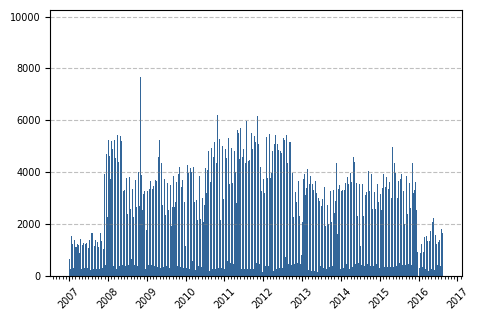

In [35]:
create_timeSeries(reuters_df_copy)

### Sort and preprocessing the data

In [5]:
# Merge both the Bloomberg and Reuters dataset
dataset_df = pd.concat([bloomberg_df, reuters_df])

In [143]:
# Rows where both the timestamp and headline are duplicated
print(dataset_df[dataset_df.duplicated(subset=['timestamp', 'headline'], keep='first')])

                timestamp                                           headline
1732     2010-04-23 20:37  Chile Plans First Overseas Peso Bond in Raisin...
2274     2010-04-27 00:34    Goldman Sachs E-Mail by Montag Faulted CDO Deal
2377     2010-04-27 05:41  Indophil Says Chinese Approval for Zijin Offer...
2475     2010-04-27 09:08  Ukraine Parliament Ratifies Russia Naval Lease...
2513     2010-04-27 10:35  Smiths Group Sells Its First-Ever Euro Bonds t...
...                   ...                                                ...
1796004  2016-08-14 15:57  Pence greets supporters at home town burger re...
1796003  2016-08-14 16:20  North Carolina mall on lockdown after reports ...
1795999  2016-08-14 18:26  Muslim imam killed, 2nd man wounded in New Yor...
2179359  2016-08-15 04:00        Violence in Milwaukee after police shooting
1609354  2016-08-16 02:46                   TABLE-Orix Jreit -6 MTH forecast

[163664 rows x 2 columns]


In [144]:
print(dataset_df.iloc[[1731, 1732]])

             timestamp                                           headline
1731  2010-04-23 20:37  Chile Plans First Overseas Peso Bond in Raisin...
1732  2010-04-23 20:37  Chile Plans First Overseas Peso Bond in Raisin...


In [6]:
dataset_df = dataset_df.drop_duplicates(subset=['timestamp', 'headline'], keep='first')

In [31]:
# Convert the 'timestamp' columns to datetime objects
dataset_df['timestamp'] = pd.to_datetime(dataset_df['timestamp'])

In [8]:
# Rows where the headline is duplicated within the same day
dataset_df['date'] = dataset_df['timestamp'].dt.date
duplicate_mask = dataset_df.duplicated(subset=['date', 'headline'], keep='first')

In [9]:
dataset_df = dataset_df[~duplicate_mask].drop(columns=['date'])

In [15]:
dataset_df.sort_values(by='timestamp', inplace=True)

In [12]:
# Rows where the headline in null
print(dataset_df[dataset_df['headline'].isna()])

                  timestamp headline
7125919 2014-09-10 07:00:00      NaN


In [14]:
dataset_df.drop(7125919, inplace=True)

In [ ]:
dataset_df['timestamp'] = dataset_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

In [28]:
# Reset the index to add a new column with the index for each row
dataset_df.reset_index(drop=True, inplace=True)

In [29]:
dataset_df.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Bloomberg & Reuters.csv')

## Final dataset

In [32]:
# Group the dataset by day
grouped = dataset_df.groupby(dataset_df['timestamp'].dt.date)

### Save each day as a .CSV file

In [33]:
output_directory = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Dataset/Bloomberg & Reuters'
os.makedirs(output_directory, exist_ok=True)

In [40]:
for date, group in grouped:
    # Format the 'timestamp' column within the group
    group['timestamp'] = group['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

    # Create a filename using the date as the name
    filename = f"{date}.csv"
    
    filepath = os.path.join(output_directory, filename)
    
    # Save the modified group to .CSV file
    group.to_csv(filepath, index=True)